## 데이터셋 생성

In [2]:
import warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import time
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [3]:
# config
root_dir = "/mnt/d/Exa/227.건설 현장 위험 상태 판단 데이터/01-1.정식개방데이터/partial_sample/"
makeset = tf.keras.utils.image_dataset_from_directory
class_type = "binary" # or "categorical"
assert class_type in ["binary", "categorical"], "typo in class_type"

# make dataset
batch_size = 64
image_size = (224, 224)
seed = 9140183 # random number
train_set = makeset(
    f"{root_dir}train",
    image_size=image_size,
    batch_size=batch_size,
    seed=seed,
    label_mode=class_type
)
valid_set = makeset(
    f"{root_dir}validation",
    image_size=image_size,
    batch_size=batch_size,
    seed=seed,
    label_mode=class_type
)
train_set.shuffle(buffer_size=200000)

Found 32000 files belonging to 2 classes.


2024-11-09 19:27:01.518523: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-09 19:27:01.652813: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-09 19:27:01.652843: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-09 19:27:01.655583: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-09 19:27:01.655612: I external/local_xla/xla/stream_executor

Found 4000 files belonging to 2 classes.


<_ShuffleDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 1), dtype=tf.float32, name=None))>

In [4]:
# check dataset
category_num = 0
for d, l in train_set:
    _, category_num = l.shape
    print(f"data batch size: {d.shape} / label batch size: {l.shape}")
    break
if category_num == 1:
	assert class_type == "binary", "분류 설정 오류"
elif category_num >= 2:
	assert class_type == "categorical", "분류 설정 오류"
else:
	raise Exception("검증 데이터셋 오류")

data batch size: (64, 224, 224, 3) / label batch size: (64, 1)


## 모델 정의

### Swish 활성화 함수 클래스 정의

In [5]:
class Swish(tf.keras.layers.Layer):
    def call(self, x):
        return x * tf.keras.activations.sigmoid(x)

### SEBlock 정의

In [6]:
def SEBlock(reduction, channels, name):
    def block(inputs):
        x = layers.GlobalAveragePooling2D(name=f"{name}_Squeeze")(inputs)
        x = layers.Reshape((1, 1, channels), name=f"{name}_Reshape")(x)
        x = layers.Conv2D(channels // reduction, kernel_size=(1, 1), activation=Swish(), name=f"{name}_Reduce")(x)
        x = layers.Conv2D(channels, kernel_size=(1, 1), activation="sigmoid", name=f"{name}_Expand")(x)
        x = layers.multiply([inputs, x], name=f"{name}_Excite")
        return x
    return block

### MBConv 정의

In [7]:
from tensorflow.keras import layers


def MBConv(kernel_size, expansion, input_channels, output_channels, strides, name):
    def block(inputs):
        x = inputs
        
        if expansion > 1:
            x = layers.Conv2D(filters=expansion * input_channels, kernel_size=(1, 1), use_bias=False, name=f"{name}_Expansion")(x)
            x = layers.BatchNormalization(name=f"{name}_BN-1")(x)
            x = Swish(name=f"{name}_Swish-1")(x)

        x = layers.DepthwiseConv2D(kernel_size=kernel_size, use_bias=False, padding='same', strides=strides, name=f"{name}_DWConv")(x)
        x = layers.BatchNormalization(name=f"{name}_BN-2")(x)
        x = Swish(name=f"{name}_Swish-2")(x)
        
        x = SEBlock(reduction=expansion * 4, channels=input_channels * expansion, name=f"{name}_SE")(x)

        x = layers.Conv2D(filters=output_channels, kernel_size=(1, 1), use_bias=False, name=f"{name}_PWConv")(x)
        x = layers.BatchNormalization(name=f"{name}_BN-3")(x)
        
        if inputs.shape == x.shape:
            x = layers.Dropout(0.2, name=f"{name}_Dropout")(x)
            x = layers.add([x, inputs], name=f"{name}_Add")
        return x
    return block

### 모델 조립

In [8]:
model_config = [
    # kernel_size, expansion, input_channels, output_channels, strides, name
    # MBConv1, k3x3, C=16,  L=1
    (3, 1, 32,  16,  1, "Stage_2-1"),
    # MBConv6, k3x3, C=24,  L=2
    (3, 6, 16,  24,  2, "Stage_3-1"),
    (3, 6, 24,  24,  1, "Stage_3-2"),
    # MBConv6, k5x5, C=40,  L=2
    (5, 6, 24,  40,  2, "Stage_4-1"),
    (5, 6, 40,  40,  1, "Stage_4-2"),
    # MBConv6, k3x3, C=80,  L=3
    (3, 6, 40,  80,  2, "Stage_5-1"),
    (3, 6, 80,  80,  1, "Stage_5-2"),
    (3, 6, 80,  80,  1, "Stage_5-3"),
    # MBConv6, k5x5, C=112, L=3
    (5, 6, 80,  112, 1, "Stage_6-1"),
    (5, 6, 112, 112, 1, "Stage_6-2"),
    (5, 6, 112, 112, 1, "Stage_6-3"),
    # MBConv6, k5x5, C=192, L=3
    (5, 6, 112, 192, 2, "Stage_7-1"),
    (5, 6, 192, 192, 1, "Stage_7-2"),
    (5, 6, 192, 192, 1, "Stage_7-3"),
    (5, 6, 192, 192, 1, "Stage_7-4"),
    # MBConv6, k3x3, C=320, L=3
    (3, 6, 192, 320, 1, "Stage_8-1")
]
final_activation = "sigmoid" if class_type == "binary" else "softmax"

inputs = tf.keras.Input(shape=(224, 224, 3), name="Inputs")
x = layers.Rescaling(1./255, name="Rescaling")(inputs)
x = layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(2, 2), padding="same", use_bias=False, name="Stage_1_Conv3x3")(x)
x = layers.BatchNormalization(name="Stage_1_BN")(x)
x = Swish(name="Stage_1_Swish")(x)

for cfg in model_config:
    x = MBConv(*cfg)(x)

x = layers.Conv2D(filters=1280, kernel_size=(1, 1), use_bias=False, name="Stage_9_Conv1x1")(x)
x = layers.BatchNormalization(name="Stage_9_BN")(x)
x = Swish(name="Stage_9_Swish")(x)
x = layers.GlobalAveragePooling2D(name="Stage_9_Pooling")(x)
x = layers.Dense(category_num, activation=final_activation, name="Stage_9_FC")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=x)
loss_function = f"{class_type}_crossentropy"
model.compile(loss=loss_function, optimizer="rmsprop", metrics=["accuracy"])

# model.summary()

### 학습

In [10]:
start = time.time()
history = model.fit(
    train_set,
    epochs=20,
    validation_data=valid_set
)
end = time.time()
print(f"Time spent: {int((end - start) // 60)}m {(end - start) % 60:.3f}s")

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 95s 186ms/step - accuracy: 0.8270 - loss: 0.3685 - val_accuracy: 0.6398 - val_loss: 1.1529
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 177ms/step - accuracy: 0.9403 - loss: 0.1481 - val_accuracy: 0.6382 - val_loss: 1.5845
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 178ms/step - accuracy: 0.9692 - loss: 0.0851 - val_accuracy: 0.6445 - val_loss: 1.8898
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 178ms/step - accuracy: 0.9800 - loss: 0.0587 - val_accuracy: 0.6712 - val_loss: 1.7413
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 91s 178ms/step - accuracy: 0.9866 - loss: 0.0409 - val_accuracy: 0.7092 - val_loss: 1.6700
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 178ms/step - accuracy: 0.9906 - loss: 0.0288 - val_accuracy: 0.6678 - val_loss: 2.3673
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 89s 176ms/step - accuracy: 0.9940 - loss: 0.0196 - val_accuracy: 0.6858 - val_loss: 2.1495
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 90s 178ms/step - accuracy: 0.9953 - loss: 0

### plot

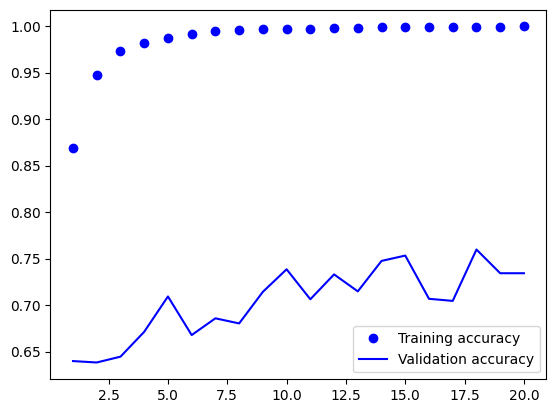

In [11]:
# plot
epochs = range(1, len(history.history["accuracy"]) + 1)
loss = history.history["accuracy"]
val_loss = history.history["val_accuracy"]
plt.figure()
plt.plot(epochs, loss, "bo", label="Training accuracy")
plt.plot(epochs, val_loss, "b", label="Validation accuracy")
plt.legend()

### Activation Map

Generating heatmap for /mnt/d/Exa/227.건설 현장 위험 상태 판단 데이터/01-1.정식개방데이터/partial_sample/validation/normal/H-220930_B13_Y-18_001_0001.jpg                      

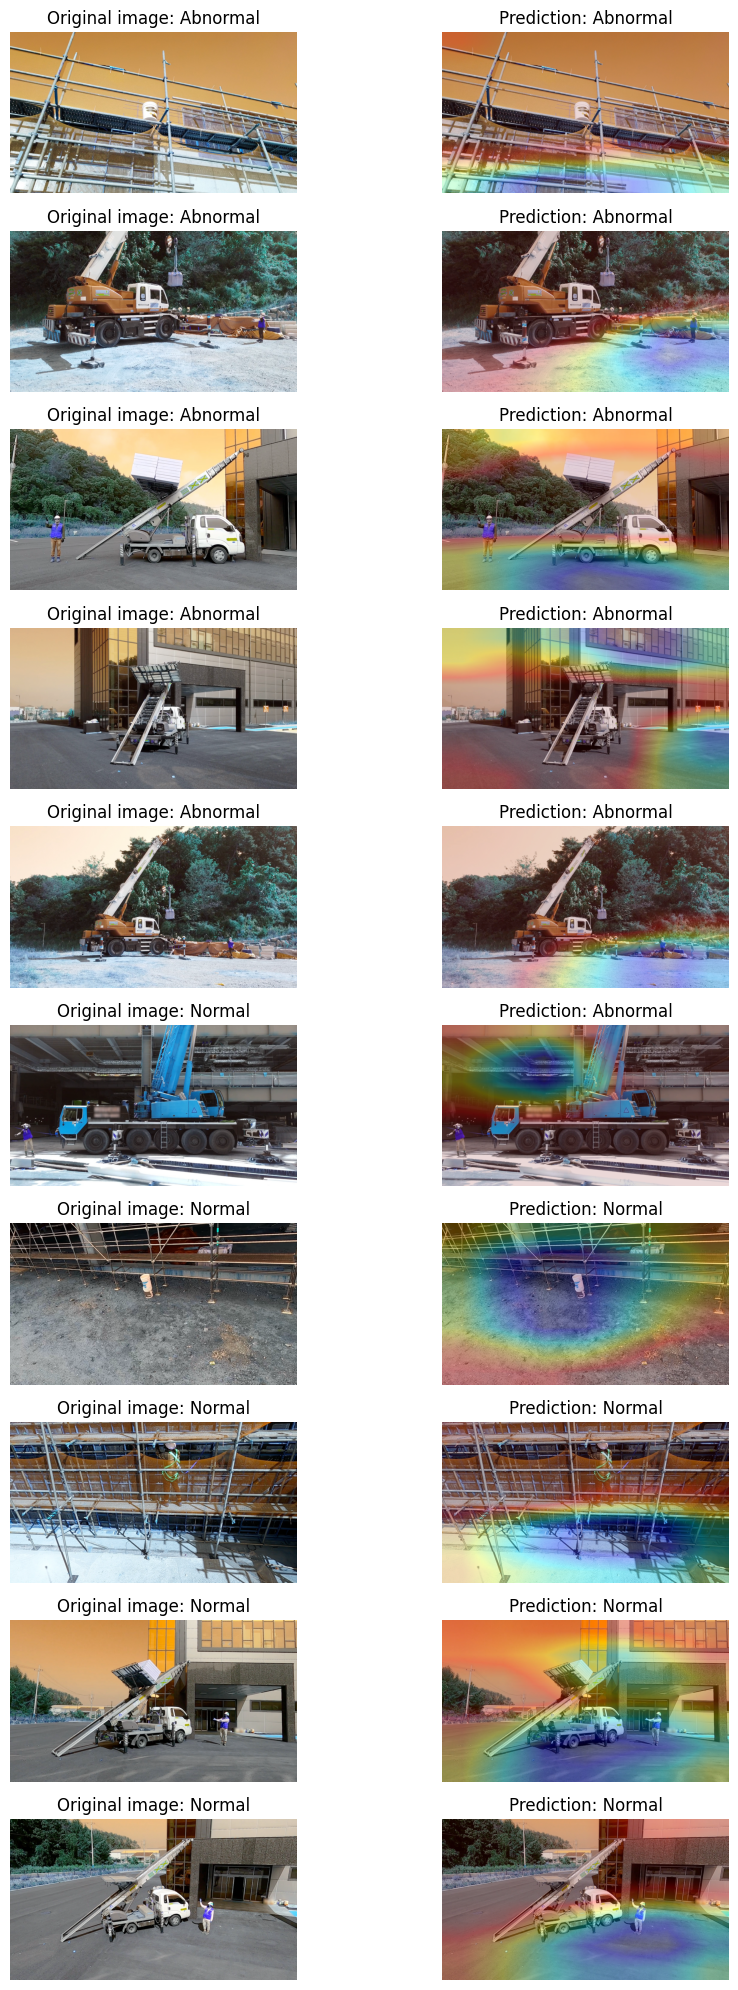

In [13]:
from tensorflow.keras import backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np
import cv2
import os
import random


last_conv_layer = model.get_layer('Stage_9_Conv1x1')
hmap_model = tf.keras.models.Model([model.input] , [last_conv_layer.output , model.output])


def preprocess_image(image_path):
    img = load_img(image_path, target_size=(224, 224))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


def make_heatmap(heatmap_model, image_path, heat_intensity=0.6):
    processed_img = preprocess_image(image_path)
    with tf.GradientTape() as gtape:
        conv_output, preds = heatmap_model(processed_img)
        loss = preds[:, np.argmax(preds[0])]
        grads = gtape.gradient(loss, conv_output)
        pooled_grads = K.mean(grads, axis=(0, 1, 2))

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_output), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    max_heat = np.max(heatmap)
    if max_heat == 0:
        max_heat = 1e-10
    heatmap /= max_heat

    org_img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    org_img = org_img / 255
    height , width , channel = org_img.shape
    heatmap_Resized = cv2.resize(heatmap[0], (width , height))
    heatmap_Resized = np.uint8(255 * heatmap_Resized)
    heatmap_Resized = cv2.applyColorMap(heatmap_Resized , cv2.COLORMAP_JET)
    superimposed_img = np.zeros((height , width , channel))

    for c in range(channel):
        for i in range(height):
            for j in range(width):
                r = max(heatmap_Resized[i][j]) / 255 * heat_intensity
                h = heatmap_Resized[i][j][c]
                v = org_img[i][j][c]
                superimposed_img[i][j][c] = (h * r / 255 + v * (2 - r)) / 2 
    return superimposed_img, preds[0]


root_dir = "/mnt/d/Exa/227.건설 현장 위험 상태 판단 데이터/01-1.정식개방데이터/partial_sample/validation/"
ls_abnormal = [f"{root_dir}abnormal/{x}" for x in os.listdir(root_dir + "abnormal")]
ls_normal = [f"{root_dir}normal/{x}" for x in os.listdir(root_dir + "normal")]
ls = [ls_abnormal[random.randrange(0, len(ls_abnormal))] for _ in range(5)] + [ls_normal[random.randrange(0, len(ls_normal))] for _ in range(5)]
fig, axes = plt.subplots(10,2, figsize=(10, 20))

# 이미지 그리기
for i, ax in enumerate(axes.flat):
    if i // 2 < len(ls):
        if i % 2 == 0:
            ax.imshow(cv2.imread(ls[i // 2], cv2.IMREAD_COLOR))
            ax.set_title("Original image: " + ("Abnormal" if "abnormal" in ls[i // 2] else "Normal"))
            ax.axis('off')
        else:
            print(f"\r[{i // 2 + 1}/{len(ls)}] Generating heatmap for {ls[i // 2].split('/')[-1]}                    ", end="")
            hmp, pred = make_heatmap(hmap_model, ls[i // 2])
            ax.imshow(hmp)  # 각 서브플롯에 이미지 표시
            ax.set_title("Prediction: " + ("Normal" if int(float(pred[0]) * 2) else "Abnormal"))
            ax.axis('off')  # 축 제거

plt.tight_layout()
plt.show()

In [ ]:
int(float(pred[0]) * 2)